In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

dataset dari https://www.kaggle.com/datasets/shaneysze/new-york-city-daily-temperature-18692021

In [10]:
df = pd.read_csv('nyc_temp_1869_2021.csv')
df.head()

,Unnamed: 0,MM/DD/YYYY,YEAR,MONTH,DAY,TMAX,TMIN
0,0,1869-01-01,1869,1,1,-17.0,-72.0
1,1,1869-01-02,1869,1,2,-28.0,-61.0
2,2,1869-01-03,1869,1,3,17.0,-28.0
3,3,1869-01-04,1869,1,4,28.0,11.0
4,4,1869-01-05,1869,1,5,61.0,28.0


In [11]:
df = df.drop(columns=["TMIN", 'Unnamed: 0'], axis=1)

In [15]:
df

,MM/DD/YYYY,YEAR,MONTH,DAY,TMAX
0,1869-01-01,1869,1,1,-17.0
1,1869-01-02,1869,1,2,-28.0
2,1869-01-03,1869,1,3,17.0
3,1869-01-04,1869,1,4,28.0
4,1869-01-05,1869,1,5,61.0
...,...,...,...,...,...
55629,2021-04-30,2021,4,30,217.0
55630,2021-05-01,2021,5,1,183.0
55631,2021-05-02,2021,5,2,278.0
55632,2021-05-03,2021,5,3,189.0


In [13]:
df.shape

(55634, 5)

In [14]:
df.isnull().sum()

MM/DD/YYYY    0
YEAR          0
MONTH         0
DAY           0
TMAX          0
dtype: int64

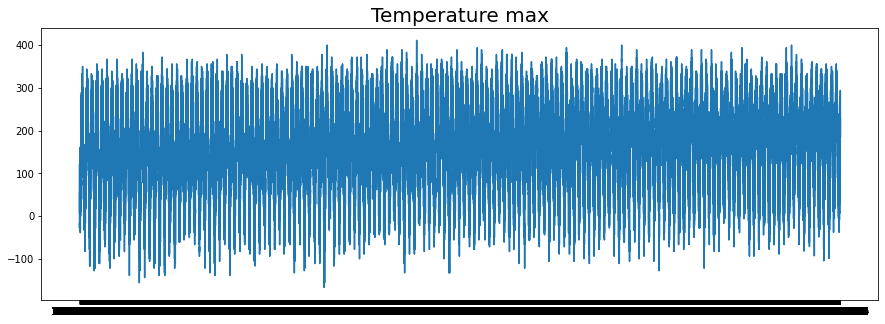

In [18]:
dates = df['MM/DD/YYYY'].values
temp  = df['TMAX'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature max',
          fontsize=20);

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
from sklearn.model_selection import train_test_split
temp_latih, temp_test, date_latih, date_test = train_test_split(temp, dates, test_size=0.2, shuffle=False)

In [32]:
data_latih = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
data_test = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [28]:
threshold_mae = (df['TMAX'].max() - df['TMAX'].min()) * 10/100
threshold_mae

57.8

In [29]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      self.model.stop_training = True
      print("\nMAE < 10%")
callbacks = myCallback()

In [33]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(data_latih ,epochs=100, validation_data=data_test, callbacks=[callbacks])

Epoch 1/100
445/445 [==============================] - 68s 144ms/step - loss: 125.4439 - mae: 125.9430 - val_loss: 60.8753 - val_mae: 61.3746
Epoch 2/100
445/445 [==============================] - ETA: 0s - loss: 57.0129 - mae: 57.5111
MAE < 10%
445/445 [==============================] - 64s 144ms/step - loss: 57.0129 - mae: 57.5111 - val_loss: 57.9396 - val_mae: 58.4351


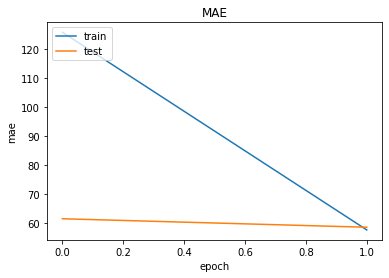

In [34]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

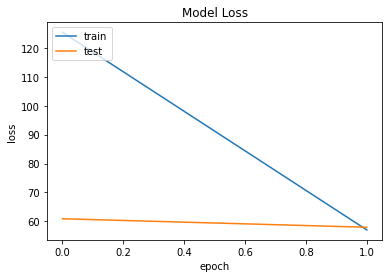

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()